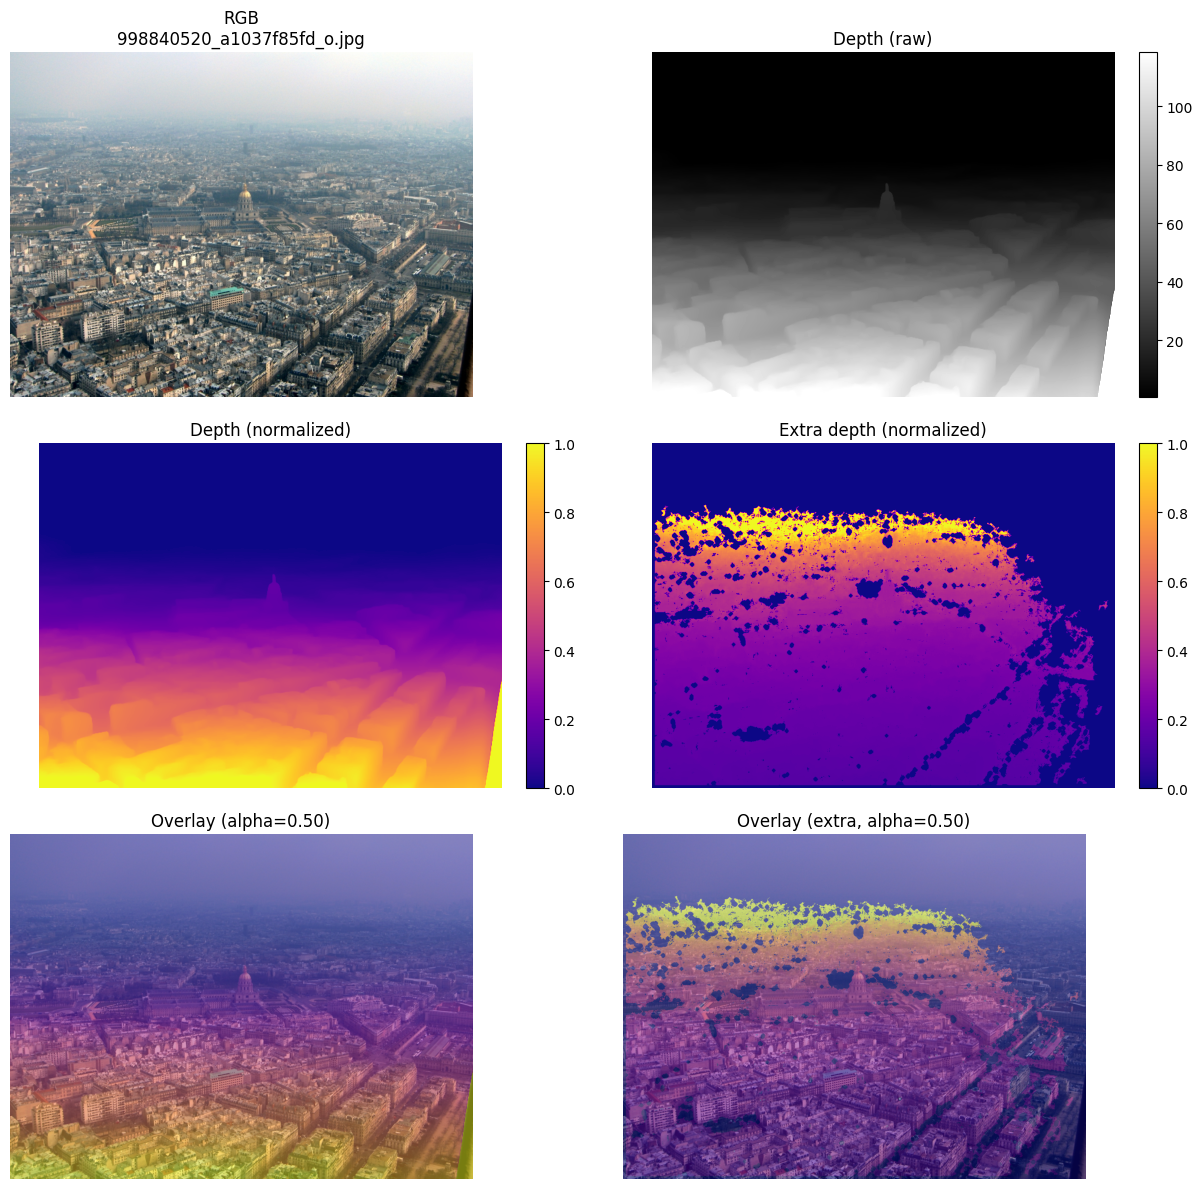

In [13]:
import h5py
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

def robust_normalize_depth(depth, eps=1e-8, clip_percentiles=(2.0, 98.0)):
    d = np.asarray(depth).astype(np.float32)
    d = np.nan_to_num(d, nan=0.0, posinf=0.0, neginf=0.0)
    lo, hi = np.percentile(d, clip_percentiles)
    if hi <= lo:
        return np.zeros_like(d, dtype=np.float32)
    d = np.clip(d, lo, hi)
    d = (d - lo) / (hi - lo + eps)
    return d

def load_depth_h5(h5_path):
    with h5py.File(h5_path, "r") as f:
        depth = np.array(f["depth"])  # [H, W]
    return depth

def colorize_norm(norm_depth, cmap="plasma"):
    """[0,1] normalized depth -> RGB uint8 (H,W,3)"""
    cm = plt.get_cmap(cmap)
    rgba = cm(norm_depth)  # [H,W,4], float in [0,1]
    rgb = (rgba[..., :3] * 255.0).astype(np.uint8)
    return rgb

def overlay_rgb_with_colormap(rgb_img, norm_depth, cmap="plasma", alpha=0.5):
    """RGB uint8 (H,W,3)와 정규화 depth(0..1)를 컬러맵으로 칠해서 알파 블렌딩"""
    colorized = colorize_norm(norm_depth, cmap=cmap).astype(np.float32)
    base = np.asarray(rgb_img).astype(np.float32)
    over = (1 - alpha) * base + alpha * colorized
    return np.clip(over, 0, 255).astype(np.uint8)

def visualize_rgb_depths(
    image_path,
    depth_path=None,
    extra_depth_path=None,
    cmap="plasma",
    title=None,
    overlay_alpha=0.5,
):
    """
    화면 구성 (3x2 = 6개):
      [0,0] RGB                          | [0,1] Depth (raw, gray)
      [1,0] Depth (normalized, cmap)     | [1,1] Extra depth (normalized, cmap)
      [2,0] RGB ⊕ Depth(norm) overlay    | [2,1] RGB ⊕ ExtraDepth(norm) overlay
    """
    image_path = Path(image_path)
    if depth_path is None:
        depth_path = image_path.with_suffix(".h5")

    # Load
    img = Image.open(image_path).convert("RGB")
    depth = load_depth_h5(depth_path)  # [H,W] float

    # 크기 불일치 방어
    if depth.shape[::-1] != img.size:
        depth = np.array(Image.fromarray(depth).resize(img.size, Image.BILINEAR))

    depth_norm = robust_normalize_depth(depth)

    # extra depth
    extra_depth = None
    extra_depth_norm = None
    if extra_depth_path is not None:
        extra_depth = load_depth_h5(extra_depth_path)
        if extra_depth.shape[::-1] != img.size:
            extra_depth = np.array(Image.fromarray(extra_depth).resize(img.size, Image.BILINEAR))
        extra_depth_norm = robust_normalize_depth(extra_depth)

    # Overlays
    overlay_main = overlay_rgb_with_colormap(img, depth_norm, cmap=cmap, alpha=overlay_alpha)
    if extra_depth_norm is not None:
        overlay_extra = overlay_rgb_with_colormap(img, extra_depth_norm, cmap=cmap, alpha=overlay_alpha)
    else:
        overlay_extra = None

    # Plot (3 rows x 2 cols)
    fig, axes = plt.subplots(3, 2, figsize=(13, 12))
    if title is None:
        title = image_path.name

    # [0,0] RGB
    axes[0, 0].imshow(img)
    axes[0, 0].set_title(f"RGB\n{title}")
    axes[0, 0].axis("off")

    # [0,1] Raw depth (gray)
    valid = depth[np.isfinite(depth) & (depth > 0)]
    if valid.size > 0:
        lo, hi = np.percentile(valid, [2.0, 98.0])
        d2 = axes[0, 1].imshow(depth, cmap="gray", vmin=lo, vmax=hi)
    else:
        d2 = axes[0, 1].imshow(depth, cmap="gray")
    axes[0, 1].set_title("Depth (raw)")
    axes[0, 1].axis("off")
    plt.colorbar(d2, ax=axes[0, 1], fraction=0.046, pad=0.04)

    # [1,0] Depth normalized (cmap)
    d3 = axes[1, 0].imshow(depth_norm, cmap=cmap, vmin=0.0, vmax=1.0)
    axes[1, 0].set_title("Depth (normalized)")
    axes[1, 0].axis("off")
    plt.colorbar(d3, ax=axes[1, 0], fraction=0.046, pad=0.04)

    # [1,1] Extra depth normalized (cmap)
    if extra_depth_norm is not None:
        d4 = axes[1, 1].imshow(extra_depth_norm, cmap=cmap, vmin=0.0, vmax=1.0)
        axes[1, 1].set_title("Extra depth (normalized)")
        axes[1, 1].axis("off")
        plt.colorbar(d4, ax=axes[1, 1], fraction=0.046, pad=0.04)
    else:
        axes[1, 1].imshow(np.zeros((img.size[1], img.size[0], 3), dtype=np.uint8))
        axes[1, 1].set_title("Extra depth (normalized) — None")
        axes[1, 1].axis("off")

    # [2,0] Overlay main
    axes[2, 0].imshow(overlay_main)
    axes[2, 0].set_title(f"Overlay (alpha={overlay_alpha:.2f})")
    axes[2, 0].axis("off")

    # [2,1] Overlay extra
    if overlay_extra is not None:
        axes[2, 1].imshow(overlay_extra)
        axes[2, 1].set_title(f"Overlay (extra, alpha={overlay_alpha:.2f})")
        axes[2, 1].axis("off")
    else:
        axes[2, 1].imshow(np.zeros((img.size[1], img.size[0], 3), dtype=np.uint8))
        axes[2, 1].set_title("Overlay (extra) — None")
        axes[2, 1].axis("off")

    plt.tight_layout()
    plt.show()

# 예시
# visualize_rgb_depths(
#     "/dataset/.../images/xxx.jpg",
#     depth_path="/dataset/.../images/xxx.h5",
#     extra_depth_path="/dataset/.../images/xxx_other.h5",
#     overlay_alpha=0.45,
# )
# 사용 예시
visualize_rgb_depths(
    "/dataset/megadepth_d2net/Undistorted_SfM/0000/images/998840520_a1037f85fd_o.jpg",
    extra_depth_path="/dataset/megadepth/phoenix/S6/zl548/MegaDepth_v1/0000/dense0/depths/998840520_a1037f85fd_o.h5",
)

In [ ]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

def show_two_images(img_path1, img_path2, layout="h", titles=None, figsize=(12, 5)):
    """
    img_path1, img_path2: 이미지 경로 (JPG/PNG 등)
    layout: "h" (가로로 2장), "v" (세로로 2장)
    titles: ["왼쪽/위 제목", "오른쪽/아래 제목"]
    """
    p1, p2 = Path(img_path1), Path(img_path2)
    img1 = Image.open(p1).convert("RGB")
    img2 = Image.open(p2).convert("RGB")

    if titles is None:
        titles = [p1.name, p2.name]

    if layout.lower() == "v":
        fig, axes = plt.subplots(2, 1, figsize=figsize)
        axes[0].imshow(img1); axes[0].set_title(titles[0]); axes[0].axis("off")
        axes[1].imshow(img2); axes[1].set_title(titles[1]); axes[1].axis("off")
    else:
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        axes[0].imshow(img1); axes[0].set_title(titles[0]); axes[0].axis("off")
        axes[1].imshow(img2); axes[1].set_title(titles[1]); axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# 사용 예시
show_two_images("/dataset/megadepth_d2net/Undistorted_SfM/0022/images/1170878020_5fb6e7c4e2_o.jpg'", "/dataset/megadepth_d2net/Undistorted_SfM/0022/images/2516964254_b7eb465903_o.jpg", layout="h")
# show_two_images("/path/to/a.jpg", "/path/to/b.jpg", layout="v", titles=["원본", "비교"])